## 导入包 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.ml.feature import StringIndexer, VectorIndexer, StandardScaler, VectorAssembler
from pyspark.ml.classification import LinearSVC
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark import Row
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors,DenseVector,VectorUDT
from pyspark.sql.functions import col
import jieba

### 数据导入

In [20]:
# 从分布式文件系统读取数据
dataset_df = spark.read \
          .format("csv") \
          .option("header", "true") \
          .option("inferSchema", "true") \
          .load('input/dataset.csv')

#数据转为dataframe并设置字段值
dataset_p = dataset_df.toPandas()
dataset_p.columns = ['target', 'text']

print(dataset_p)

       target                                               text
0           1  专门选在工作日过来体验一下融汇温泉，大大小小的池子还是种类很多，从下午一直泡到晚上天黑，也是...
1           1  这次是夜场换票的人很多，说实话同程做的还可以就是排队的次序上再加强一点就好了。然后是温泉，感...
2           1  评价有点晚了，完全是值啊值啊，一元钱的门票，进去了还有免费的水果一份，温泉种类也很多，这种泡...
3           1  一块钱能玩到已经很不错了，但是在同程取票那里工作人员态度不太好，我把手机给他，他写完后往旁边...
4           1  距主城温泉水质最棒哒哒的哦；员工服务比较好，时不时都要提醒游客；配套设施完善（网吧，亲子乐园...
...       ...                                                ...
33793       1                                  非常好，好玩的很多，里面都不要钱的
33794       1                                      刚开的，夜景非常nice。
33795       1                                      不错！！！方便，快捷！！！
33796       0                                        和女朋友一起的，还行吧
33797       0  差评送给里面的餐厅，景区里面卖得贵可以理解，但是你好歹还是得让人吃饱吧，一份香菇滑鸡套饭，一...

[33798 rows x 2 columns]


In [32]:
dataset_1 = spark.read \
          .format("csv") \
          .option("header", "true") \
          .option("inferSchema", "true") \
          .load('input/a1.csv')

dataset_2 = spark.read \
          .format("csv")\
          .option("header", "true") \
          .option("inferSchema", "true") \
          .load('input/a2.csv')

#数据转为dataframe并设置字段值
dataset_1 = dataset_1.toPandas()
dataset_1.columns = ['id','target', 'text']
dataset_1.drop(['id'],axis=1)

#数据转为dataframe并设置字段值
dataset_2 = dataset_2.toPandas()
dataset_2.columns = ['id','target', 'text']
dataset_2.drop(["id"],axis=1)

dataset = pd.merge(dataset_1,dataset_2,how="outer")
dataset_p = dataset
print(dataset)

2022-11-17 18:35:40,662 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , label, review
 Schema: _c0, label, review
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/user/huashuimu/input/a1.csv
2022-11-17 18:35:42,628 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , label, review
 Schema: _c0, label, review
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/user/huashuimu/input/a2.csv


          id  target                                               text
0          0       1                         就是太热了，而且没有小时候的那种感觉了，完全变完了。
1          1       1                                游玩很满意，可玩性很高，还会再来体验的
2          2       1                                      好非常好很好，玩那个地方。
3          3       1                                         不错，很好的旅游经历
4          4       0  丰都给人的感觉不像个旅游城市，公共交通非常不到位，公交车等待时间少则半小时，多则1个多小时。...
...      ...     ...                                                ...
88765  33793       1                                  非常好，好玩的很多，里面都不要钱的
88766  33794       1                                      刚开的，夜景非常nice。
88767  33795       1                                      不错！！！方便，快捷！！！
88768  33796       0                                        和女朋友一起的，还行吧
88769  33797       0  差评送给里面的餐厅，景区里面卖得贵可以理解，但是你好歹还是得让人吃饱吧，一份香菇滑鸡套饭，一...

[88770 rows x 3 columns]


### 数据预处理

In [33]:
#数据去掉缺失值
dataset_z = dataset_p.dropna()

#数据去掉留言重复值
dataset_z.drop_duplicates(keep='first',inplace=True,subset='text')

#索引重排：因为前面取出来重复值和缺失值，索引不连续了
dataset_z = dataset_z.reset_index()

# 文本分词，去除停用词。停用词有专门的停用词库，但是这里没有调用，因为jieba内置了停用词去除功能
text = dataset_z.text.values.tolist()
words = [" ".join(jieba.lcut(i)) for i in text]
new_text = pd.core.frame.DataFrame({"text":words})

# 更新数据框：删除没用的列
dataset_z.drop(["text"],axis=1)
dataset_z["text"] = new_text

print(dataset_z)

       index     id  target                                               text
0          0      0       1          就是 太热 了 ， 而且 没有 小时候 的 那种 感觉 了 ， 完全 变完 了 。
1          1      1       1                    游玩 很 满意 ， 可玩性 很 高 ， 还会 再 来 体验 的
2          2      2       1                             好 非常 好 很 好 ， 玩 那个 地方 。
3          3      3       1                                   不错 ， 很 好 的 旅游 经历
4          4      4       0  丰都 给 人 的 感觉 不像 个 旅游 城市 ， 公共交通 非常 不 到位 ， 公交车 等待...
...      ...    ...     ...                                                ...
19168  80251  25278       0                          带 小朋友 玩玩 看看 可以 ， 很小 的 海洋馆
19169  80291  25318       1  在 内陆 城市 这样 的 海洋馆 还是 不错 ， 和 沿海 城市 的 比 起来 差距 就 大...
19170  80292  25319       0  19.9 元 买 的 ， 最多 也 就 值 这个 价 ， 2 个 小时 耍 完 足够 ， 离...
19171  80638  25665       1                                  不 需要 取票 ， 扫码 进 方便
19172  80639  25666       1                                 吗 丁啉 ： 没有 我 看 下 还有

[19173 rows x 4 columns]


### 将数据传入Spark sql

In [34]:
dataset_df = sqlContext.createDataFrame(dataset_z)

### 设定数据预处理pipeline

In [35]:
#文本分词到words字段
tokenizer = Tokenizer(inputCol="text", outputCol="words")

#对words字段计算词频并transforme到tf字段
hashtf = HashingTF(numFeatures=256, inputCol="words", outputCol='tf')

#对tf字段计算tf-idf，降低多文档高频词权重
idf = IDF(inputCol='tf', outputCol="rawfeatures", minDocFreq=5)

#将上述操作放到pipeline中以备使用
pipeline = Pipeline(stages=[tokenizer, hashtf, idf])

### 特征提取

In [36]:
# 这个代码逻辑可以这样理解：（不一定准确）
# 首先要定义一个管道对象。通过对Pipeline类调用fit方法生成这样的管道对象，并且已经声明了这个管道中有哪些方法，各个方法会依此执行
# 随后，对管道对象调用transform方法，就可以执行管道中的所有方法，产生输出

pipelineFit = pipeline.fit(dataset_df)
dataset_df = pipelineFit.transform(dataset_df)

dataset_df.show(5)

+-----+---+------+-------------------------------+----------------------------+--------------------+--------------------+
|index| id|target|                           text|                       words|                  tf|         rawfeatures|
+-----+---+------+-------------------------------+----------------------------+--------------------+--------------------+
|    0|  0|     1|就是 太热 了 ， 而且 没有 小...|[就是, 太热, 了, ，, 而且...|(256,[15,73,107,1...|(256,[15,73,107,1...|
|    1|  1|     1|游玩 很 满意 ， 可玩性 很 高...|[游玩, 很, 满意, ，, 可玩...|(256,[24,64,97,10...|(256,[24,64,97,10...|
|    2|  2|     1| 好 非常 好 很 好 ， 玩 那个...|  [好, 非常, 好, 很, 好, ...|(256,[11,24,36,75...|(256,[11,24,36,75...|
|    3|  3|     1|     不错 ， 很 好 的 旅游 经历|  [不错, ，, 很, 好, 的, ...|(256,[24,36,153,1...|(256,[24,36,153,1...|
|    4|  4|     0| 丰都 给 人 的 感觉 不像 个 ...| [丰都, 给, 人, 的, 感觉,...|(256,[2,8,9,20,24...|(256,[2,8,9,20,24...|
+-----+---+------+-------------------------------+----------------------------+--------------------+-----------

### 建模前数据准备

In [37]:
# 设定数据标签
labelIndexer = StringIndexer(inputCol="target", outputCol="label").fit(dataset_df)
dataset_df = labelIndexer.transform(dataset_df)

# 特征标准化
normalizer = StandardScaler(inputCol="rawfeatures", outputCol="features")
normalizer_model = normalizer.fit(dataset_df)
dataset_labeled_df = normalizer_model.transform(dataset_df)

# 去除前面处理遗留的无用字段
dataset_labeled_df = dataset_labeled_df.select("features","label")

# 数据集分割
(training_data, test_data) = dataset_labeled_df.randomSplit([0.7, 0.3])

### 建模并训练、预测

In [38]:
# 配置模型参数
dtree = lr = LinearSVC(maxIter=256,threshold=0.5)

# 模型训练
model = lr.fit(training_data)

# 模型检验
predictions = model.transform(test_data)

### 模型评估

In [39]:
#导入评估模块
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [40]:


#计算准确率
acc_evaluator_dt = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy_dt = acc_evaluator_dt.evaluate(predictions)
print("Acc: %g" % (accuracy_dt))



Acc: 0.856419


In [41]:
#计算F1值
f1_evaluator_dt = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
f1_score_dt= f1_evaluator_dt.evaluate(predictions)
print("F1: %g" % (f1_score_dt))

F1: 0.790181


### 结果可视化

In [42]:
#将标准化特征字段数据的SparkVector类型转为Array类型
from pyspark.sql.functions import UserDefinedFunction
def convert_to_dense(col):
  return DenseVector(col.toArray())
convert_to_dense_udf = UserDefinedFunction(lambda x: convert_to_dense(x),VectorUDT())
test_dataset_labeled_df = test_data.withColumn("dense_features", convert_to_dense_udf(col("features")))

In [43]:
#利用PCA对Array类型标准化特征进行降维
PCA_m = PCA(k=2,inputCol="dense_features", outputCol="pcaFeatures")
PCA_model_cluster = PCA_m.fit(test_dataset_labeled_df)
test_data_points = PCA_model_cluster.transform(test_dataset_labeled_df).select("pcaFeatures","label")

In [44]:
#获取绘图数据
test_data_points_l = test_data_points.rdd.map(lambda x: (x[0].toArray(),x[1])).collect()
test_x = list(map(lambda x: x[0][0], test_data_points_l))
test_y = list(map(lambda x: x[0][1], test_data_points_l))
test_class = list(map(lambda x: x[1], test_data_points_l))
colors = ['red' if label == 1 else 'blue' for label in test_class]

In [17]:
#去除奇异值
def del_point(nums=1):
    for _ in range(nums):
        del_index = test_x.index(max(test_x))
        del test_x[del_index]
        del test_y[del_index]
        del colors[del_index]
        del_index = test_x.index(min(test_x))
        del test_x[del_index]
        del test_y[del_index]
        del colors[del_index]
        del_index = test_y.index(max(test_y))
        del test_x[del_index]
        del test_y[del_index]
        del colors[del_index]
        del_index = test_y.index(min(test_y))
        del test_x[del_index]
        del test_y[del_index]
        del colors[del_index]
del_point(10)

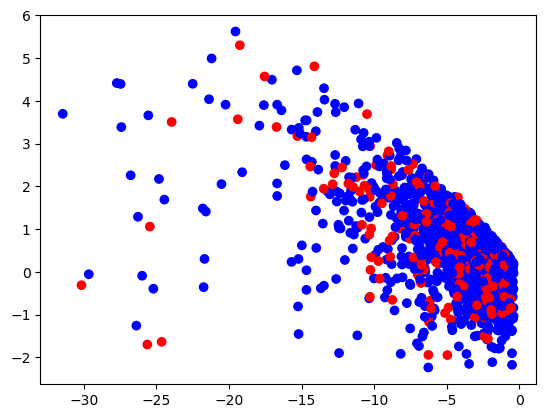

In [18]:
#绘图
plt.scatter(test_x, test_y, c = colors)